# Prediction of Department: Fine-Tuning a Classification Model


In [41]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, classification_report

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
from sklearn.utils import resample
from matplotlib import pyplot as plt

In [42]:
GH_USER = "luisadosch"
GH_REPO = "Final-Project-snapAddy"
BRANCH = "main"


def get_github_url(relative_path):
    return f"https://raw.githubusercontent.com/{GH_USER}/{GH_REPO}/{BRANCH}/{relative_path}"

In [43]:
jobs_annotated = pd.read_csv(get_github_url("data/processed/jobs_annotated.csv"))
df_department = pd.read_csv(get_github_url("data/raw/department-v2.csv"))

# test set from annotated CVs (ACTIVE only) -> out-of-production set
jobs_annotated_df = jobs_annotated.loc[
    jobs_annotated["status"] == "ACTIVE",
    ["position", "department"]
].copy()

jobs_annotated_df = jobs_annotated_df.rename(columns={"position": "text", "department": "label"})

# base train/test dfs (strings)
df_department = df_department[["text", "label"]].copy()
jobs_annotated_df = jobs_annotated_df[["text", "label"]].copy()

print("fine tuning data:", len(df_department), "CV labeled data:", len(jobs_annotated_df))
print("fine-tune label counts:\n", df_department["label"].value_counts())
print("out-of-production label counts:\n", jobs_annotated_df["label"].value_counts())

fine tuning data: 10145 CV labeled data: 623
fine-tune label counts:
 label
Marketing                 4295
Sales                     3328
Information Technology    1305
Business Development       620
Project Management         201
Consulting                 167
Administrative              83
Other                       42
Purchasing                  40
Customer Support            33
Human Resources             31
Name: count, dtype: int64
out-of-production label counts:
 label
Other                     344
Information Technology     62
Sales                      46
Consulting                 39
Project Management         39
Marketing                  22
Business Development       20
Human Resources            16
Purchasing                 15
Administrative             14
Customer Support            6
Name: count, dtype: int64


In [44]:
train_df_base, temp_df = train_test_split(
    df_department,
    test_size=0.30,              # 70% train, 30% temp
    stratify=df_department["label"],
    random_state=42,
)

val_df_base, df_department_test = train_test_split(
    temp_df,
    test_size=0.50,              # 15% val, 15% test
    stratify=temp_df["label"],
    random_state=42,
)

print("train:", len(train_df_base), "val:", len(val_df_base), "test:", len(df_department_test))
print("train label counts:\n", train_df_base["label"].value_counts())
print("val label counts:\n", val_df_base["label"].value_counts())
print("test label counts:\n", df_department_test["label"].value_counts())

train: 7101 val: 1522 test: 1522
train label counts:
 label
Marketing                 3006
Sales                     2330
Information Technology     913
Business Development       434
Project Management         141
Consulting                 117
Administrative              58
Other                       29
Purchasing                  28
Customer Support            23
Human Resources             22
Name: count, dtype: int64
val label counts:
 label
Marketing                 644
Sales                     499
Information Technology    196
Business Development       93
Project Management         30
Consulting                 25
Administrative             12
Other                       7
Purchasing                  6
Human Resources             5
Customer Support            5
Name: count, dtype: int64
test label counts:
 label
Marketing                 645
Sales                     499
Information Technology    196
Business Development       93
Project Management         30
Consulting      

In [45]:
def add_synthetic_department(train_df: pd.DataFrame, synthetic_csv_relpath: str) -> pd.DataFrame:
    syn = pd.read_csv(get_github_url(synthetic_csv_relpath))

    # expect columns: position, department
    syn = syn[["position", "department"]].copy()
    syn = syn.rename(columns={"position": "text", "department": "label"})
    syn = syn.dropna(subset=["text", "label"])

    out = pd.concat([train_df[["text", "label"]], syn[["text", "label"]]], ignore_index=True)
    return out


In [46]:
MODEL_CKPT = "xlm-roberta-base"
MAX_LEN = 80

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )

In [47]:
def to_hf_dataset(df: pd.DataFrame, label_col: str = "labels") -> Dataset:
    ds = Dataset.from_pandas(df[["text", label_col]].copy(), preserve_index=False)
    ds = ds.map(tokenize, batched=True)
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", label_col])
    return ds

In [48]:
def eval_split(trainer, train_ds, val_ds, test_ds):
    train_metrics = trainer.evaluate(train_ds)
    val_metrics   = trainer.evaluate(val_ds)
    test_metrics  = trainer.evaluate(test_ds)
    print("train:", train_metrics)
    print("val:  ", val_metrics)
    print("test: ", test_metrics)
    return train_metrics, val_metrics, test_metrics

In [49]:
def loss_curves(trainer):
    logs = pd.DataFrame(trainer.state.log_history)

    train_loss = logs.dropna(subset=["loss"])[["step", "loss"]].copy()
    eval_loss  = logs.dropna(subset=["eval_loss"])[["step", "eval_loss"]].copy()

    plt.figure()
    plt.plot(train_loss["step"], train_loss["loss"])
    plt.xlabel("step")
    plt.ylabel("train loss")
    plt.title("Train loss")
    plt.show()

    plt.figure()
    plt.plot(eval_loss["step"], eval_loss["eval_loss"])
    plt.xlabel("step")
    plt.ylabel("eval loss")
    plt.title("Eval loss")
    plt.show()

    return logs

classification pipeline

In [50]:
def compute_metrics_cls(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

In [51]:
def predict_table_cls(trainer, ds, df_text_label, id2label):
    pred = trainer.predict(ds)
    probs = pred.predictions
    y_pred = np.argmax(probs, axis=-1)

    out = df_text_label.copy().reset_index(drop=True)
    out["pred_id"] = y_pred
    out["pred_label"] = [id2label[int(i)] for i in y_pred]
    out["correct"] = (out["pred_label"] == out["label"])
    return out

In [52]:
def report_cls(trainer, ds, id2label):
    pred = trainer.predict(ds)
    y_pred = np.argmax(pred.predictions, axis=-1)
    y_true = pred.label_ids
    print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))

In [77]:
def oversample_df(df, label_col="label", random_state=42):
    max_n = df[label_col].value_counts().max()
    parts = []
    for lab, g in df.groupby(label_col):
        parts.append(resample(g, replace=True, n_samples=max_n, random_state=random_state))
    return pd.concat(parts).sample(frac=1, random_state=random_state).reset_index(drop=True)


def run_classification(
    train_df,
    val_df,
    test_df,
    out_dir="dept_cls",
    do_oversample=False,
    random_state=42,
):
    # label space ONLY from train_df (no leakage)
    label_list = sorted(train_df["label"].unique())
    label2id = {l: i for i, l in enumerate(label_list)}
    id2label = {i: l for l, i in label2id.items()}

    tr = train_df.copy()
    va = val_df.copy()
    te = test_df.copy()

    tr["labels"] = tr["label"].map(label2id).astype(int)
    va["labels"] = va["label"].map(label2id)
    te["labels"] = te["label"].map(label2id)

    # oversample train only (optional)
    train_os = tr
    if do_oversample:
        train_os = oversample_df(tr, label_col="label", random_state=random_state)

    train_ds = to_hf_dataset(train_os, label_col="labels")
    val_ds = to_hf_dataset(va, label_col="labels")
    test_ds = to_hf_dataset(te, label_col="labels")

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    )

    args = TrainingArguments(
        output_dir=out_dir,
        learning_rate=1e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=10,
        weight_decay=0.05,
        warmup_ratio=0.06,
        do_eval=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        load_best_model_at_end=False,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        fp16=True,
        report_to="none",
        dataloader_num_workers=0,
        logging_strategy="steps",
        logging_steps=50,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_cls,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    trainer.train()

    eval_split(trainer, train_ds, val_ds, test_ds)
    loss_curves(trainer)

    train_pred = predict_table_cls(trainer, train_ds, train_os[["text", "label"]], id2label)
    val_pred = predict_table_cls(trainer, val_ds, va[["text", "label"]], id2label)
    test_pred = predict_table_cls(trainer, test_ds, te[["text", "label"]], id2label)

    report_cls(trainer, val_ds, id2label)

    return trainer, (train_pred, val_pred, test_pred), (label2id, id2label)


model runs

classification without synth. data

In [54]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("cuda device count:", torch.cuda.device_count())
print("current device:", torch.cuda.current_device() if torch.cuda.is_available() else None)
print("gpu name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)

torch: 2.9.0+cu126
cuda available: True
cuda device count: 1
current device: 0
gpu name: Tesla T4


classification with synthetic data

1) Normal (no synthetic, no oversampling)

Map:   0%|          | 0/7101 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2272987538.py:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.348700,0.195962,0.940867,0.395356
2,0.150100,0.102529,0.980946,0.674538
3,0.041000,0.090550,0.981603,0.739367
4,0.065300,0.063786,0.988173,0.893209
5,0.026500,0.073155,0.990145,0.939120
6,0.018100,0.055802,0.992773,0.967358
7,0.008800,0.049279,0.993430,0.977394
8,0.017300,0.047753,0.994744,0.982233
9,0.004200,0.050408,0.994744,0.982233
10,0.001300,0.050167,0.994744,0.982233


train: {'eval_loss': 0.0030890319030731916, 'eval_accuracy': 0.9995775242923531, 'eval_f1_macro': 0.9978491487191569, 'eval_runtime': 7.335, 'eval_samples_per_second': 968.1, 'eval_steps_per_second': 30.266, 'epoch': 10.0}
val:   {'eval_loss': 0.04775337129831314, 'eval_accuracy': 0.9947437582128777, 'eval_f1_macro': 0.9822328737651499, 'eval_runtime': 1.5801, 'eval_samples_per_second': 963.207, 'eval_steps_per_second': 30.377, 'epoch': 10.0}
test:  {'eval_loss': 0.02005433663725853, 'eval_accuracy': 0.9967148488830486, 'eval_f1_macro': 0.9655042752154782, 'eval_runtime': 1.5743, 'eval_samples_per_second': 966.799, 'eval_steps_per_second': 30.49, 'epoch': 10.0}


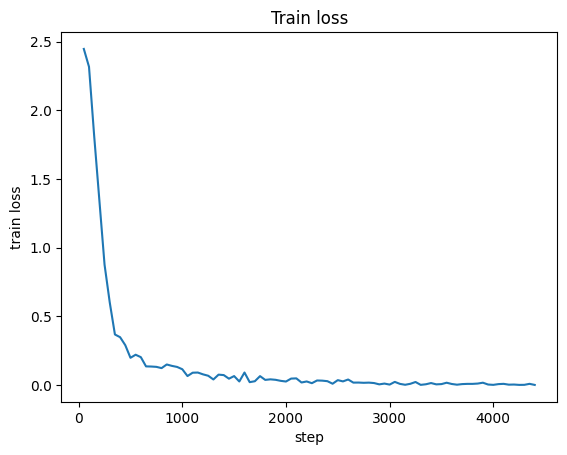

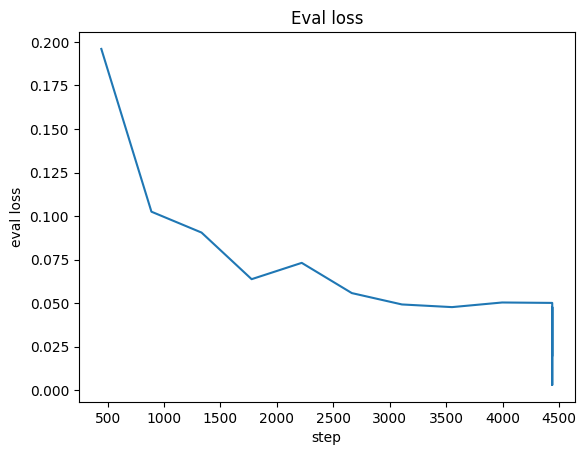

                        precision    recall  f1-score   support

        Administrative       1.00      0.92      0.96        12
  Business Development       0.99      1.00      0.99        93
            Consulting       1.00      0.96      0.98        25
      Customer Support       0.83      1.00      0.91         5
       Human Resources       1.00      1.00      1.00         5
Information Technology       0.99      0.98      0.99       196
             Marketing       1.00      1.00      1.00       644
                 Other       1.00      1.00      1.00         7
    Project Management       1.00      0.97      0.98        30
            Purchasing       1.00      1.00      1.00         6
                 Sales       1.00      1.00      1.00       499

              accuracy                           0.99      1522
             macro avg       0.98      0.98      0.98      1522
          weighted avg       0.99      0.99      0.99      1522



In [55]:
dept_trainer_base, (dept_train_pred, dept_val_pred, dept_test_pred), (label2id_dept, id2label_dept) = run_classification(
    train_df_base,
    val_df_base,
    df_department_test,
    out_dir="department_cls_base"
)



In [56]:
cv_dept = jobs_annotated_df[["text", "label"]].copy()
cv_dept["labels"] = cv_dept["label"].map(label2id_dept).astype(int)

cv_dept_ds = to_hf_dataset(cv_dept, label_col="labels")

cv_dept_pred = predict_table_cls(
    dept_trainer_base,
    cv_dept_ds,
    cv_dept[["text", "label"]],
    id2label_dept
)

print("CV accuracy:", cv_dept_pred["correct"].mean())
print("CV F1 macro:", f1_score(cv_dept_pred["label"], cv_dept_pred["pred_label"], average="macro"))



Map:   0%|          | 0/623 [00:00<?, ? examples/s]

CV accuracy: 0.29373996789727125
CV F1 macro: 0.3937368525971099


2) No synthetic + oversampling

Map:   0%|          | 0/33066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2272987538.py:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.037400,0.064225,0.991459,0.975401
2,0.000500,0.062295,0.992116,0.973423
3,0.000200,0.054227,0.993430,0.980112
4,0.000100,0.050661,0.994087,0.991885
5,0.000000,0.055875,0.993430,0.983383
6,0.000100,0.041437,0.995401,0.996235
7,0.000000,0.053888,0.993430,0.987078
8,0.000000,0.051337,0.994744,0.987714


train: {'eval_loss': 1.564798367326148e-05, 'eval_accuracy': 1.0, 'eval_f1_macro': 1.0, 'eval_runtime': 33.9657, 'eval_samples_per_second': 973.51, 'eval_steps_per_second': 30.442, 'epoch': 8.0}
val:   {'eval_loss': 0.04143736511468887, 'eval_accuracy': 0.9954007884362681, 'eval_f1_macro': 0.9962345571352089, 'eval_runtime': 1.6253, 'eval_samples_per_second': 936.459, 'eval_steps_per_second': 29.534, 'epoch': 8.0}
test:  {'eval_loss': 0.00894458033144474, 'eval_accuracy': 0.9980289093298291, 'eval_f1_macro': 0.9810260833397081, 'eval_runtime': 1.6323, 'eval_samples_per_second': 932.41, 'eval_steps_per_second': 29.406, 'epoch': 8.0}


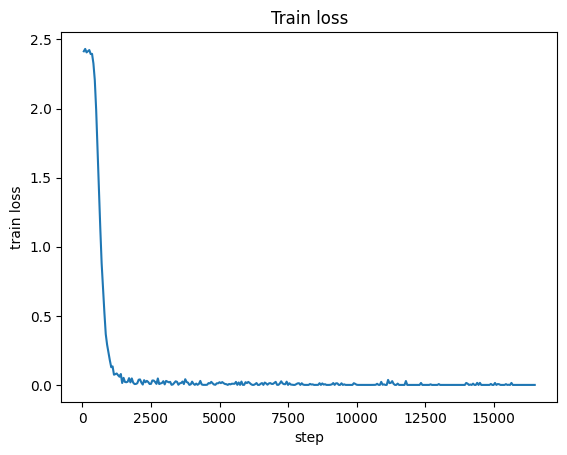

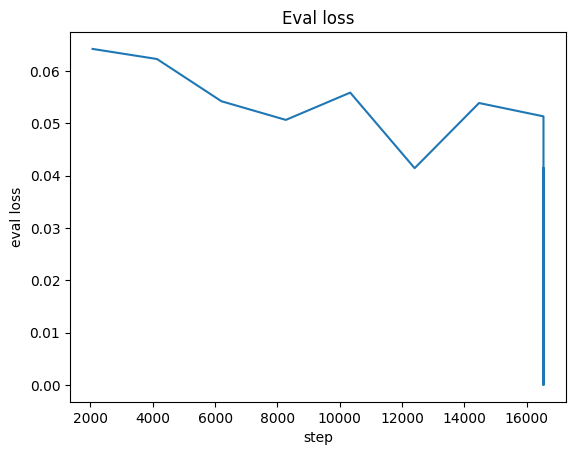

                        precision    recall  f1-score   support

        Administrative       1.00      1.00      1.00        12
  Business Development       0.99      1.00      0.99        93
            Consulting       1.00      1.00      1.00        25
      Customer Support       1.00      1.00      1.00         5
       Human Resources       1.00      1.00      1.00         5
Information Technology       0.99      0.98      0.99       196
             Marketing       1.00      1.00      1.00       644
                 Other       1.00      1.00      1.00         7
    Project Management       1.00      0.97      0.98        30
            Purchasing       1.00      1.00      1.00         6
                 Sales       1.00      1.00      1.00       499

              accuracy                           1.00      1522
             macro avg       1.00      1.00      1.00      1522
          weighted avg       1.00      1.00      1.00      1522



In [58]:
dept_trainer_os, (dept_train_pred, dept_val_pred, dept_test_pred), (label2id_dept, id2label_dept) = run_classification(
    train_df_base,
    val_df_base,
    df_department_test,
    out_dir="department_cls_os",
    do_oversample=True
)


In [60]:
cv_dept_pred_os = predict_table_cls(
    dept_trainer_os,
    cv_dept_ds,
    cv_dept[["text", "label"]],
    id2label_dept
)

print("CV accuracy:", cv_dept_pred_os["correct"].mean())
print("CV F1 macro:", f1_score(cv_dept_pred_os["label"], cv_dept_pred_os["pred_label"], average="macro"))

CV accuracy: 0.2953451043338684
CV F1 macro: 0.3801560365849907


## 3) With synthetic

In [61]:
train_df_aug = add_synthetic_department(train_df_base, "data/results/gemini_synthetic.csv")

In [62]:
# show how often the different labels occur in train_df_aug

train_df_aug["label"].value_counts()

,count
label,
Marketing,3106
Sales,2500
Information Technology,1084
Other,806
Business Development,575
Project Management,261
Consulting,244
Administrative,156
Human Resources,101


Map:   0%|          | 0/7101 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3545150955.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.314700,0.198992,0.959264,0.476479
2,0.179500,0.104030,0.978318,0.662063
3,0.057500,0.073788,0.986859,0.872662
4,0.074400,0.060435,0.989488,0.916247
5,0.006100,0.058197,0.992116,0.956760
6,0.028900,0.049019,0.992773,0.960641
7,0.019800,0.041586,0.994087,0.969768
8,0.027100,0.044192,0.994087,0.971787
9,0.006500,0.045776,0.994744,0.978224
10,0.004400,0.043228,0.994744,0.978224


train: {'eval_loss': 0.0016771922819316387, 'eval_accuracy': 0.9998591747641177, 'eval_f1_macro': 0.9999306825963461, 'eval_runtime': 7.4688, 'eval_samples_per_second': 950.759, 'eval_steps_per_second': 29.724, 'epoch': 10.0}
val:   {'eval_loss': 0.043227747082710266, 'eval_accuracy': 0.9947437582128777, 'eval_f1_macro': 0.9782238559121754, 'eval_runtime': 1.6007, 'eval_samples_per_second': 950.823, 'eval_steps_per_second': 29.987, 'epoch': 10.0}
test:  {'eval_loss': 0.020759830251336098, 'eval_accuracy': 0.9967148488830486, 'eval_f1_macro': 0.9709092949878975, 'eval_runtime': 1.6091, 'eval_samples_per_second': 945.889, 'eval_steps_per_second': 29.831, 'epoch': 10.0}


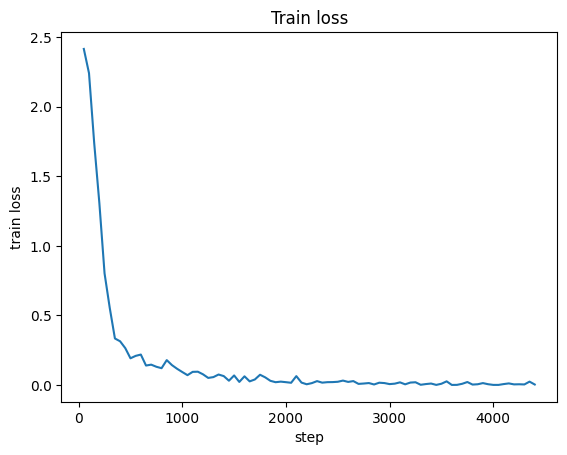

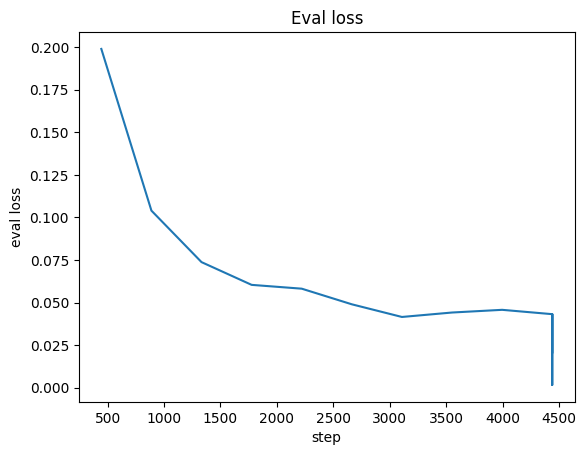

                        precision    recall  f1-score   support

        Administrative       1.00      0.83      0.91        12
  Business Development       0.99      1.00      0.99        93
            Consulting       0.96      1.00      0.98        25
      Customer Support       0.83      1.00      0.91         5
       Human Resources       1.00      1.00      1.00         5
Information Technology       0.99      0.98      0.99       196
             Marketing       1.00      1.00      1.00       644
                 Other       1.00      1.00      1.00         7
    Project Management       1.00      0.97      0.98        30
            Purchasing       1.00      1.00      1.00         6
                 Sales       1.00      1.00      1.00       499

              accuracy                           0.99      1522
             macro avg       0.98      0.98      0.98      1522
          weighted avg       0.99      0.99      0.99      1522



In [86]:
dept_trainer_aug, (dept_train_pred_aug, dept_val_pred_aug, dept_test_pred_aug), (label2id_dept, id2label_dept) = run_classification(
    train_df_base,
    val_df_base,
    df_department_test,
    out_dir="department_cls_aug",
    do_oversample=False
)


In [ ]:
cv_dept_pred_aug = predict_table_cls(
    dept_trainer_aug,
    cv_dept_ds,
    cv_dept[["text", "label"]],
    id2label_dept
)

print("CV accuracy:", cv_dept_pred_aug["correct"].mean())
print("CV F1 macro:", f1_score(cv_dept_pred_aug["label"], cv_dept_pred_aug["pred_label"], average="macro"))